# ===========================
# Benchmarking the PPI 
# ===========================

In [2]:
# import
from multidimvis_main import *

In [97]:
def embed_umap_2D(Matrix, n_neighbors, spread, min_dist, metric='cosine', learn_rate = 1, n_ep = None):
    '''
    Dimensionality reduction from Matrix using UMAP.
    Return dict (keys: node IDs, values: x,y).
    ''' 
    n_components = 2 

    U = umap.UMAP(
        n_neighbors = n_neighbors,
        spread = spread,
        min_dist = min_dist,
        n_components = n_components,
        metric = metric, 
        random_state=42,
        learning_rate = learn_rate, 
        n_epochs = n_ep)
    
    embed = U.fit_transform(Matrix)
    
    return embed

In [4]:
################################################
#
# Y E A S T 
#
################################################

organism = 'Yeast'

data = pickle.load( open( "input/BIOGRID-ORGANISM-Saccharomyces_cerevisiae_S288c-3.5.185.mitab.pickle", "rb" ) )

filter_score = data[
                    #(data['Interaction Types'] == 'psi-mi:"MI:0915"(physical association)') +
                    (data['Interaction Types'] == 'psi-mi:"MI:0407"(direct interaction)') 
                    #&
                    #(data['Taxid Interactor A'] == "taxid:559292") & 
                    #(data['Taxid Interactor B'] == "taxid:559292") 
]

g = nx.from_pandas_edgelist(filter_score, '#ID Interactor A', 'ID Interactor B')
g.remove_edges_from(nx.selfloop_edges(g)) #remove self loop

G_cere = g.subgraph(max(nx.connected_components(g), key=len)) # largest connected component (lcc)
G = G_cere

posG_entrez = []
for k in G.nodes():
    posG_entrez.append(k[22:])
    
df_gID_sym = pd.read_csv('input/Yeast_geneID_sym.csv', index_col=0)
gene_sym = list(df_gID_sym['Sym'])
gene_id = list(df_gID_sym.index)
g_ID_sym = dict(list(zip(gene_id, gene_sym)))
#len(g_ID_sym)
    
l_features = []
for i in g_ID_sym.values():
    l_features.append(i)
    
# ESSENTIALITY 

cere_gene =pd.read_csv("input/Saccharomyces cerevisiae.csv",
           delimiter= ',',
           skipinitialspace=True)
 
cere_sym = list(cere_gene['symbols'])
cere_ess = list(cere_gene['essentiality status'])
cere_sym_essentiality = dict(zip(cere_sym, cere_ess))

d_cere_ess = {}
d_cere_noess = {}
d_cere_unknown = {}

for node,es in cere_sym_essentiality.items():
    if es == 'E':
        d_cere_ess[node]=es
    elif es == 'NE':
        d_cere_noess[node]=es
        
d_cere_alless = {}
for nid, sym in g_ID_sym.items():
    for sy,ess in cere_sym_essentiality.items():
        if sym == sy:
            d_cere_alless[nid] = ess
            
d_cere_unknown = {} 
for g in G.nodes():
    if g not in d_cere_alless.keys():
        d_cere_unknown[g]='status unkonwn'
    
d_geneID_ess = {**d_cere_unknown, **d_cere_alless}

d_gID_ess = {}
d_gID_noess = {}
d_gID_notdef = {}

for k,i in d_geneID_ess.items():
    if i == 'E':
        d_gID_ess[k] = i
    elif i == 'NE':
        d_gID_noess[k] = i
    else: 
        d_gID_notdef[k] = 'not defined'

d_gID_all_unsorted = {**d_gID_ess, **d_gID_noess, **d_gID_notdef}
d_gID_all = {key:d_gID_all_unsorted[key] for key in G.nodes()}

essential_genes = []
non_ess_genes = []
notdefined_genes = [] 
for k,v in d_gID_all.items():
    if v == 'E':
        essential_genes.append(k)
    elif v == 'NE':
        non_ess_genes.append(k)
    else:
        notdefined_genes.append(k)
        
# Centrality features 
df_centralities = pd.read_csv('_output_csv/Features_centralities_Dataframe_'+organism+'.csv', index_col=0)

d_deghubs = dict(zip(G.nodes(), df_centralities['degs']))
d_clos = dict(zip(G.nodes(), df_centralities['clos']))
d_betw = dict(zip(G.nodes(), df_centralities['betw']))
d_eigen = dict(zip(G.nodes(), df_centralities['eigen']))

d_centralities = dict(zip(list(G.nodes),zip(d_deghubs.values(),d_clos.values(),d_betw.values(),d_eigen.values())))

cent_features = []
for i in d_centralities.items():
    k=list(i)
    cent_features.append(k)

## NETWORK

In [5]:
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
print('Network density: %.11f%%' %(200.*len(list(G.edges()))/(len(list(G.nodes()))*len(list(G.nodes()))-1)))

Network: Yeast
Number of nodes: 5785
Number of edges: 31237
Network density: 0.18667776801%


____________
## PRE-SETTINGS
____________

+ PREDEFINED FEATURE MATRIX

In [6]:
# DEGREE CENTRALITY - Node degree: important nodes being involved within high number of interactions
degs = dict(G.degree())
d_deghubs = {}
for node, de in sorted(degs.items(),key = lambda x: x[1], reverse = 1):
    d_deghubs[node] = round(float(de/max(degs.values())),4)
    
# CLOSENESSCENTRALITY - Measures how closely a node is connected to all other nodes to highlight f.ex. core-periphery structure, or identify central nodes
closeness = nx.closeness_centrality(G)
d_clos = {}
for node, cl in sorted(closeness.items(), key = lambda x: x[1], reverse = 1):
    d_clos[node] = round(cl,4)
    
# BETWEENESS CENTRALITY - How many shortest paths between pairs of other nodes in the network go through one node. High BC indicates "bottleneck nodes" in the network
betweens = nx.betweenness_centrality(G)
d_betw = {}
for node, be in sorted(betweens.items(), key = lambda x: x[1], reverse = 1):
     d_betw[node] = round(be,4)
    
# EIGENVECTOR CENTRALITY - Compute the eigenvector centrality for the graph
eigen = nx.eigenvector_centrality(G)
d_eigen = {}
for node, eig in sorted(eigen.items(), key = lambda x: x[1], reverse = 1):
     d_eigen[node] = round(eig,4)
    
d_deghubs_sorted = {key:d_deghubs[key] for key in sorted(d_deghubs.keys())}
d_clos_sorted = {key:d_clos[key] for key in sorted(d_clos.keys())}
d_betw_sorted = {key:d_betw[key] for key in sorted(d_betw.keys())}
d_eigen_sorted = {key:d_eigen[key] for key in sorted(d_eigen.keys())}

# feature collection
feature_dict = dict(zip(d_deghubs_sorted.keys(), zip(
                                                     d_deghubs_sorted.values(), 
                                                     d_clos_sorted.values(), 
                                                     d_betw_sorted.values(), 
                                                     d_eigen_sorted.values(),
                                                    )))

# IMPORTANT :
# sort all feature according to Graph node IDs
feature_dict_sorted = {key:feature_dict[key] for key in G.nodes()}
feature_df = pd.DataFrame.from_dict(feature_dict_sorted, orient = 'index', columns = ['degs', 
                                                                                      'clos', 
                                                                                      'betw', 
                                                                                      'eigen',
                                                                                      ]) 


# CENTRALITY 

metric = "cosine" 
DM_cent = pd.DataFrame(distance.squareform(distance.pdist(feature_df, metric)))
DM_cent.index = list(G.nodes())
DM_cent.columns = list(G.nodes())

#round(DM_cent,2)

In [7]:
# General Parameters:
# Node, Edge colors

edge_width = 2
edge_col = 'lightgrey'
edge_colordark = 'dimgrey'
opacity_edges = 0.5

opacity_nodes = 1.0
node_edge_col = 'black'

# Node sizes 

#scalef= 0.2
#size = list(draw_node_degree(G, scalef).values())

#scalef= 0.05
#size3d = list(draw_node_degree_3D(G, scalef).values())

color_method = 'deg'
d_colours = color_nodes_from_dict(G, d_deghubs, palette = 'YlOrRd')
colours = list(d_colours.values())

labelsize = 18
legendfontsize = 12

___________
## NETWORK DISTANCE 
___________

In [8]:
%%time 

d_idx_entz = {}
cc = 0
for entz in sorted(G.nodes()):
    d_idx_entz[cc] = entz
    cc += 1

Mspl = np.zeros(len(list(G.nodes())))

for n1 in range(len(list(G.nodes()))):
    vec = []
    for n2 in range(len(list(G.nodes()))):
        geneA = d_idx_entz[n1]
        geneB = d_idx_entz[n2]
        try:
            spl = round(nx.shortest_path_length(G,geneA,geneB),1)
            vec.append(spl)
        except nx.NetworkXNoPath:
            print('no path')
        
    Mspl = np.vstack((Mspl,vec))
Mspl = np.delete(Mspl, (0), axis=0)

DM_spl = pd.DataFrame(Mspl, columns = list(G.nodes()), index=list(G.nodes()))

#DM_spl.astype(int)

df = DM_spl 
x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
DM_spl_norm = pd.DataFrame(x_scaled)

CPU times: user 1h 24min 5s, sys: 4min 15s, total: 1h 28min 21s
Wall time: 1h 28min 43s


______________
# 2D BENCHMARK - visual + statistical 
______________

### SPRING

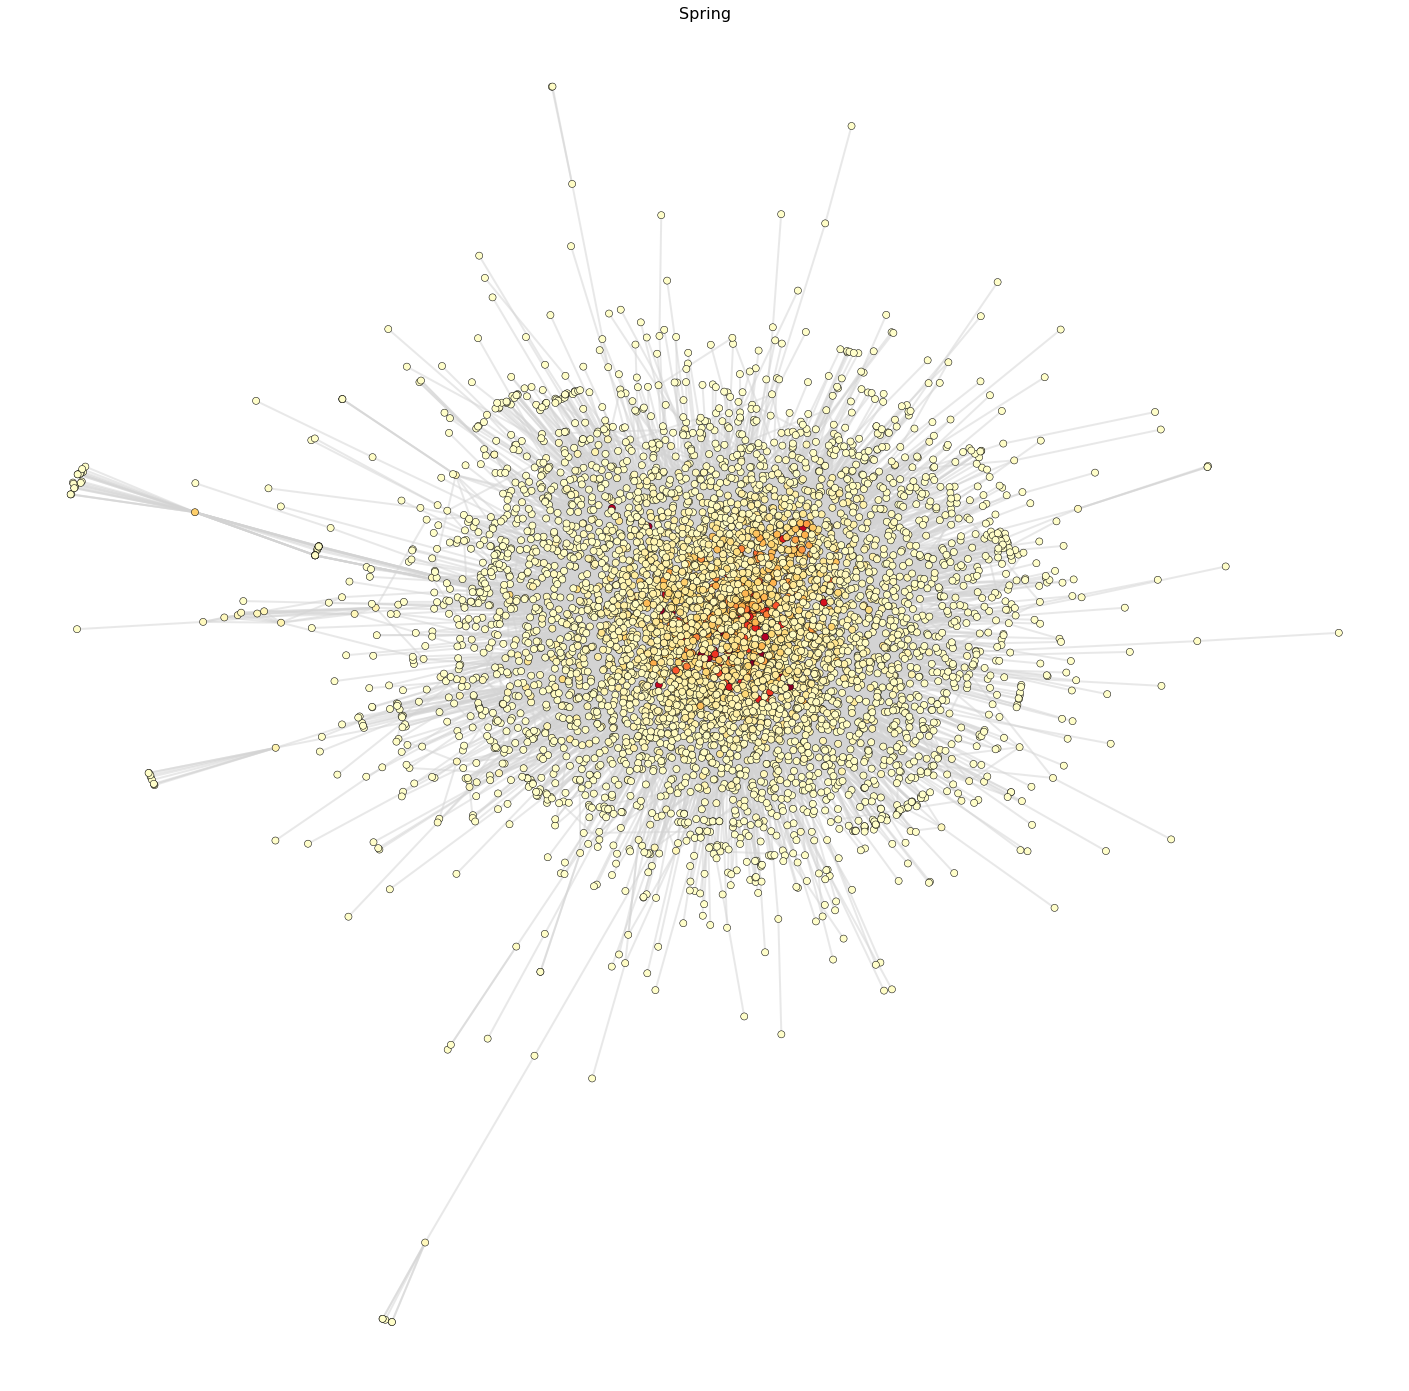

CPU times: user 1min 30s, sys: 3.39 s, total: 1min 34s
Wall time: 1min 15s


In [99]:
%%time

niter = 50 
posG_spring2D = nx.spring_layout(G, iterations = niter, dim = 2)

df_posG = pd.DataFrame(posG_spring2D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring2D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

plt.figure(figsize=(25,25))
plt.title('Spring', size= 16)

nx.draw_networkx_nodes(G, posG_spring2D_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color = colours, 
                       node_size= 50, #size, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_spring2D_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)

plt.box(False)

plt.savefig('output_plots/2Dspring_'+organism+'.png')

plt.show()

## 2D PORTRAITS 

+ ADJACENCIES

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 34513 edges.
It has only fully disconnected 27 vertices.
Use umap.utils.disconnected_vertices() to identify them.



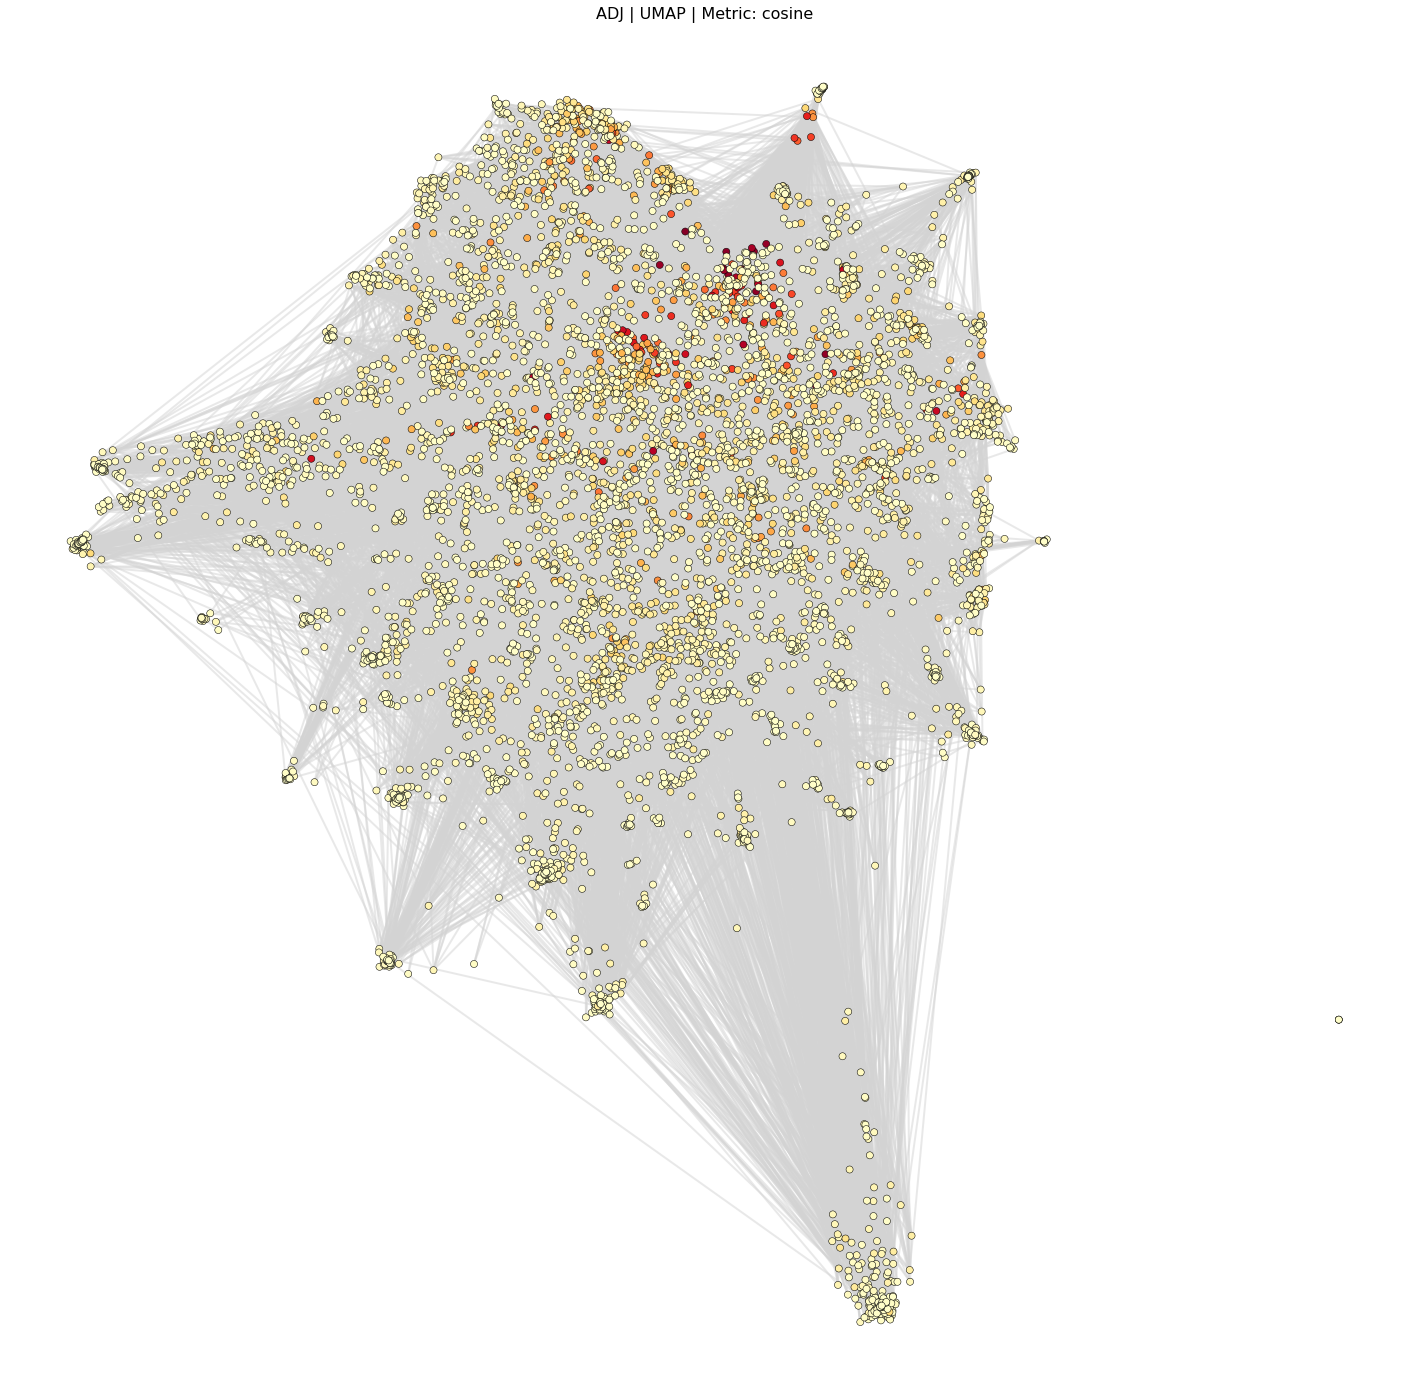

CPU times: user 1min 55s, sys: 26.3 s, total: 2min 21s
Wall time: 1min 34s


In [48]:
%%time

n_neighbors = 50 # 20 # balance between local and global structure in the data
spread = 1.0 # 10
min_dist = 0.1 # 0.9 #defines how dense points are stacked together 
metric ='cosine'

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
df_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))
DM = df_adj

umap_adj = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

posG_umap_adj = get_posG_2D(list(G.nodes()), umap_adj)
posG_complete_umap_adj = {key:posG_umap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_adj_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_adj_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

+ RANDOM WALK - visiting probability 

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



Network: Yeast
Number of nodes: 5785
Number of edges: 31237


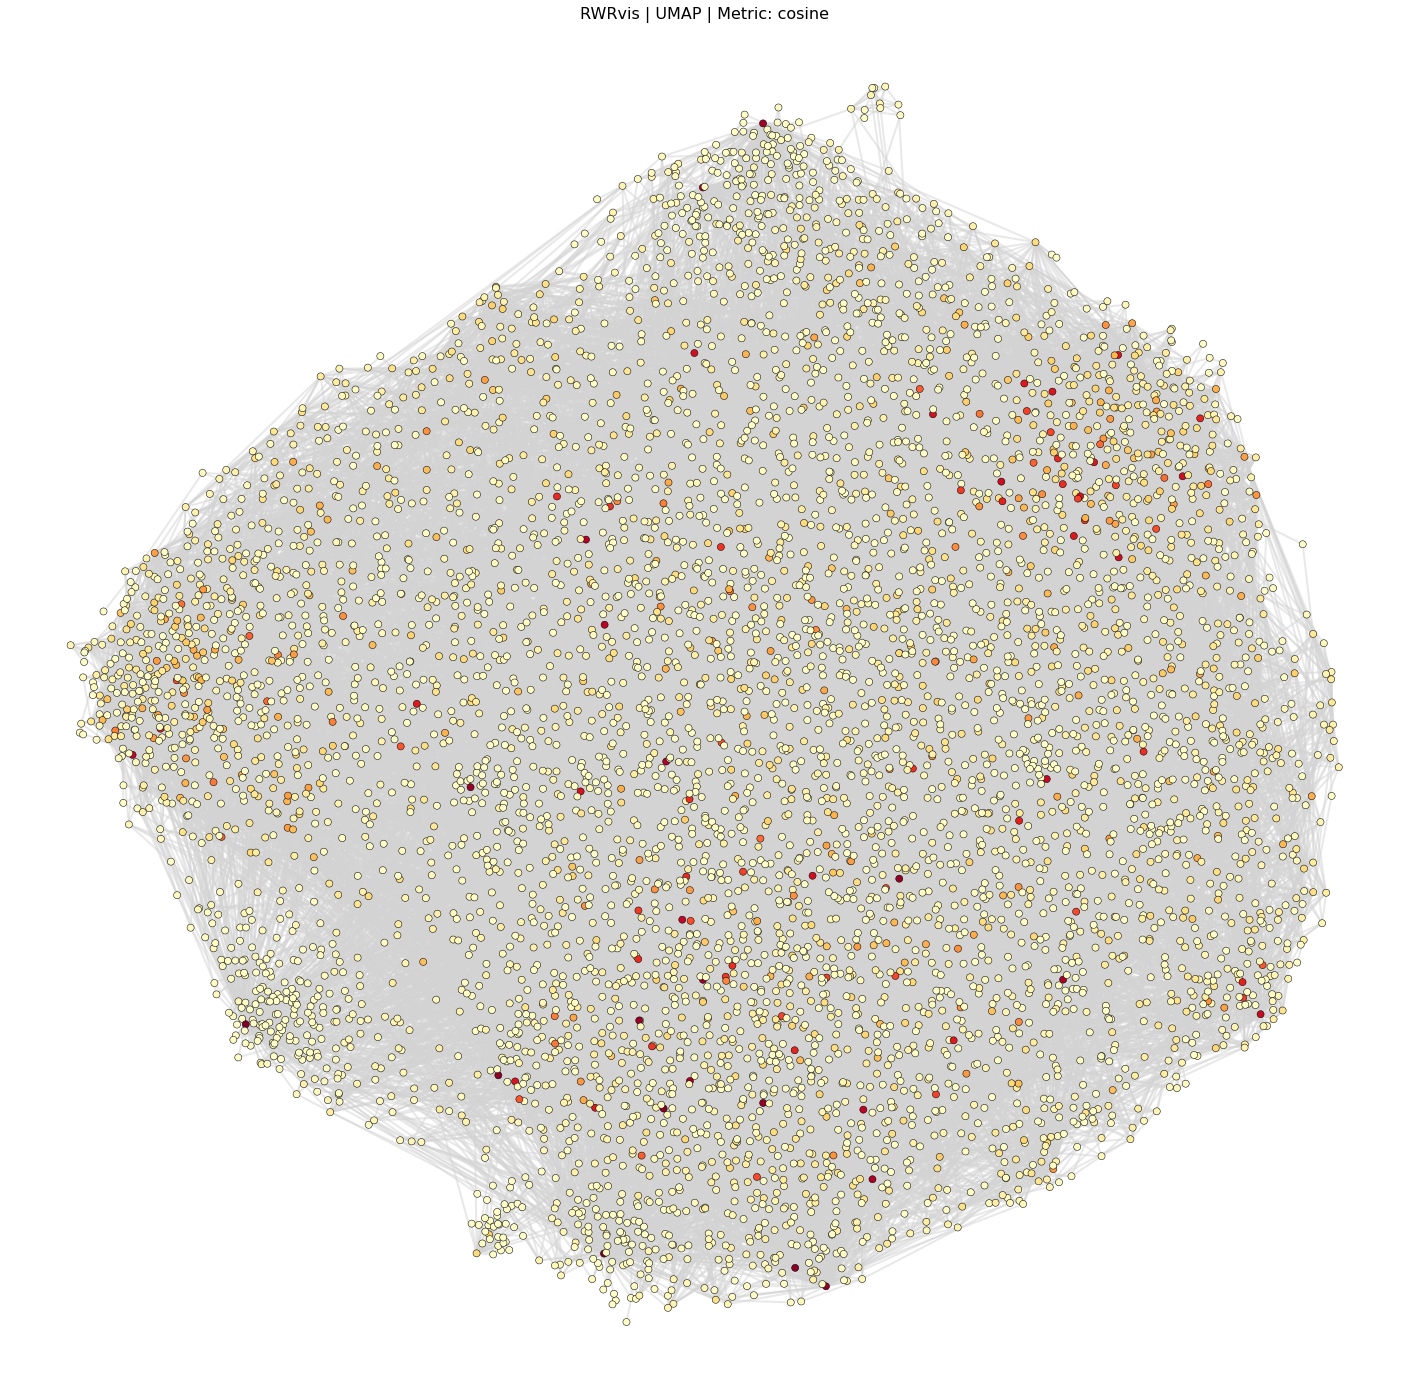

CPU times: user 9min 11s, sys: 41.5 s, total: 9min 53s
Wall time: 3min 9s


In [120]:
%%time 

n_neighbors = int(deg_max) #deg_max # 8
spread = 10.0 # 2.0
min_dist = 0.1 # 0.5
metric ='cosine'
lnr = 1
nep = None

feature = 'RWRvis'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

A = nx.adjacency_matrix(G)
FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
FM_m_transposed = FM_m#.T
DM=FM_m_transposed

umap_rwr = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric, learn_rate = lnr, n_ep = nep)

posG_umap_rwr = get_posG_2D(list(G.nodes()), umap_rwr)
posG_complete_umap_rwr = {key:posG_umap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))

plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_rwr_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, #100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_rwr_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')
print('Network:', organism)
print('Number of nodes: %s' %len(list(G.nodes())))
print('Number of edges: %s' %len(list(G.edges())))
plt.show()

+ FEATURE MATRIX = CENTRALITIES

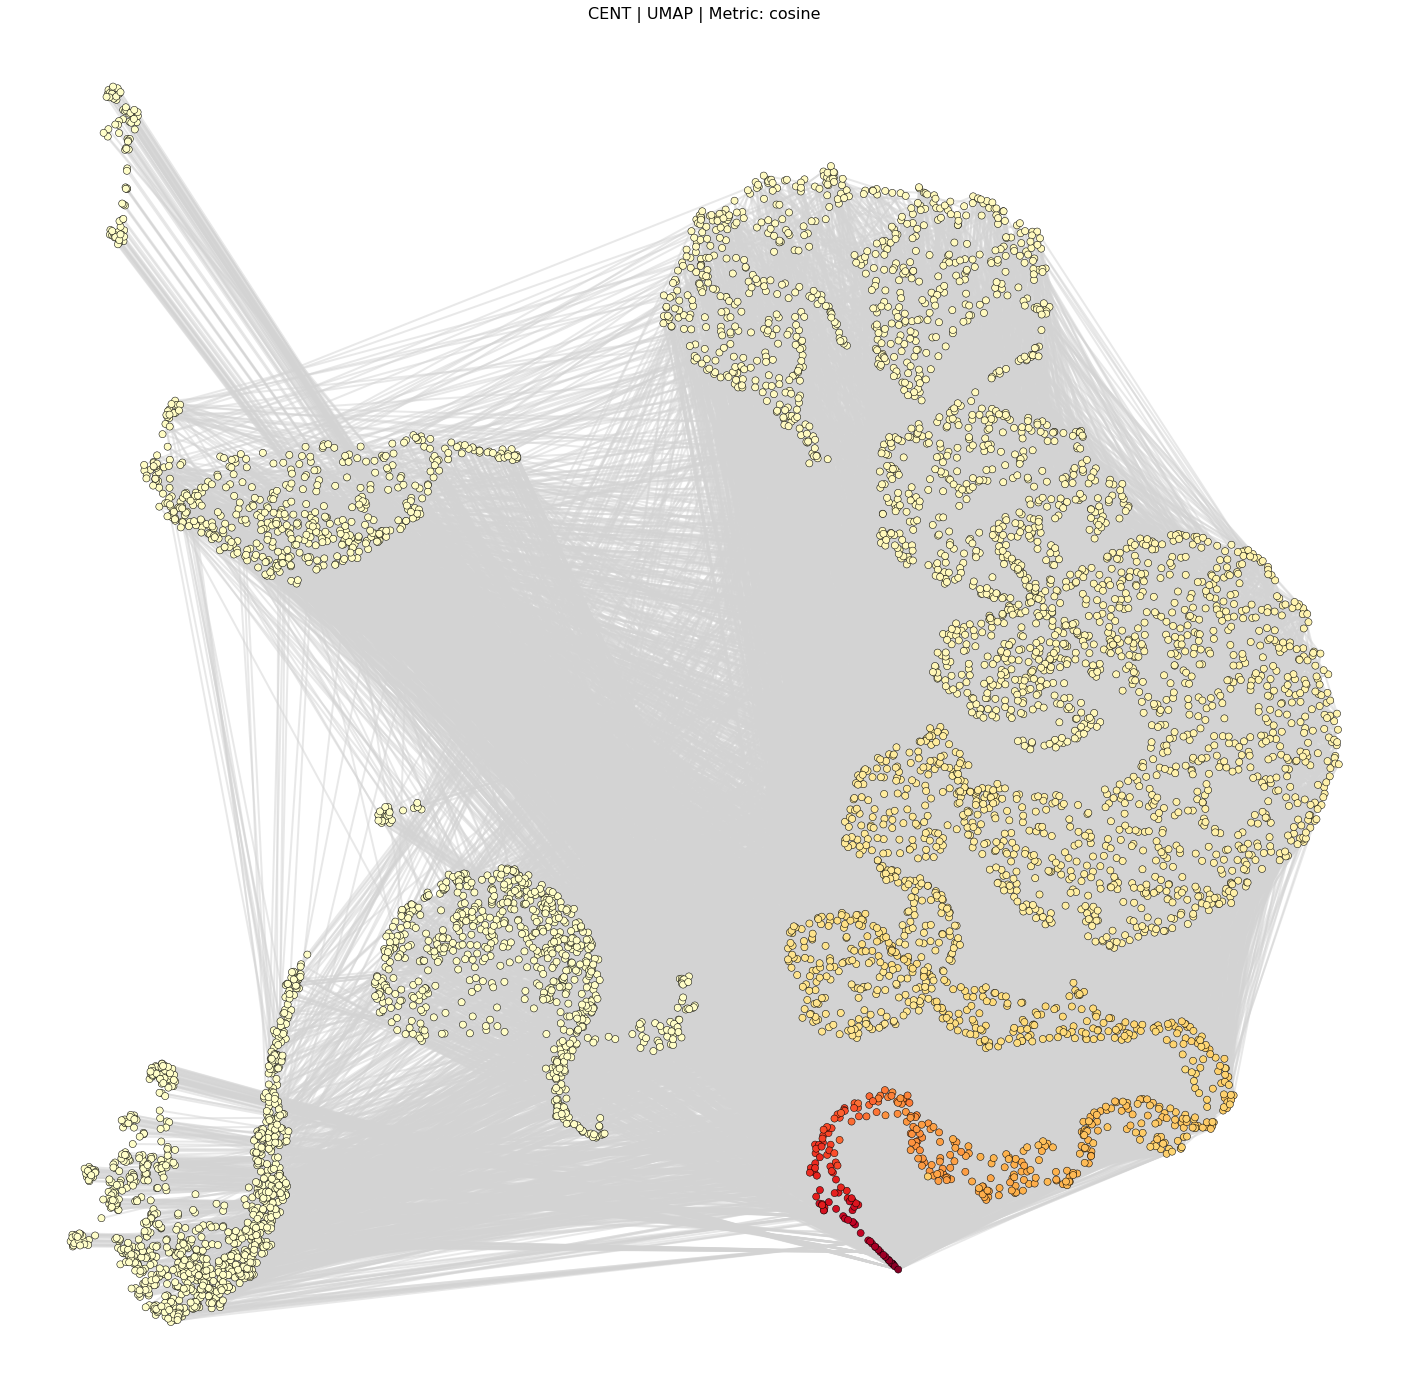

CPU times: user 26.7 s, sys: 482 ms, total: 27.2 s
Wall time: 21.3 s


In [34]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.9 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'
DM = DM_cent

umap_cent = embed_umap_2D(DM, n_neighbors, spread, min_dist, metric)

posG_umap_cent = get_posG_2D(list(G.nodes()), umap_cent)
posG_complete_umap_cent = {key:posG_umap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values)))


plt.figure(figsize=(25,25))
plt.title(
    feature+' | UMAP | Metric: '+metric, size=16)

nx.draw_networkx_nodes(G, posG_complete_umap_cent_norm, edgecolors = node_edge_col, linewidths = 0.5, node_color=colours, 
                       node_size = 50, #100, 
                       alpha = opacity_nodes)
nx.draw_networkx_edges(G, posG_complete_umap_cent_norm, width = edge_width, 
                       edge_color = edge_col, alpha = opacity_edges)
plt.box(False)

plt.savefig('output_plots/2Dtoynetworkumap_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

plt.show()

_________

# EVALUATION - 2D
### Network Distance vs. Layout Distance 
+ Plots to compare Network Distances (i.e. SPL) with embedded Layout Distances 
+ X-axis = Reference axis i.e. Network Distance 
+ Y-axis = Layout Distance 

## 2D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

+ SPRING

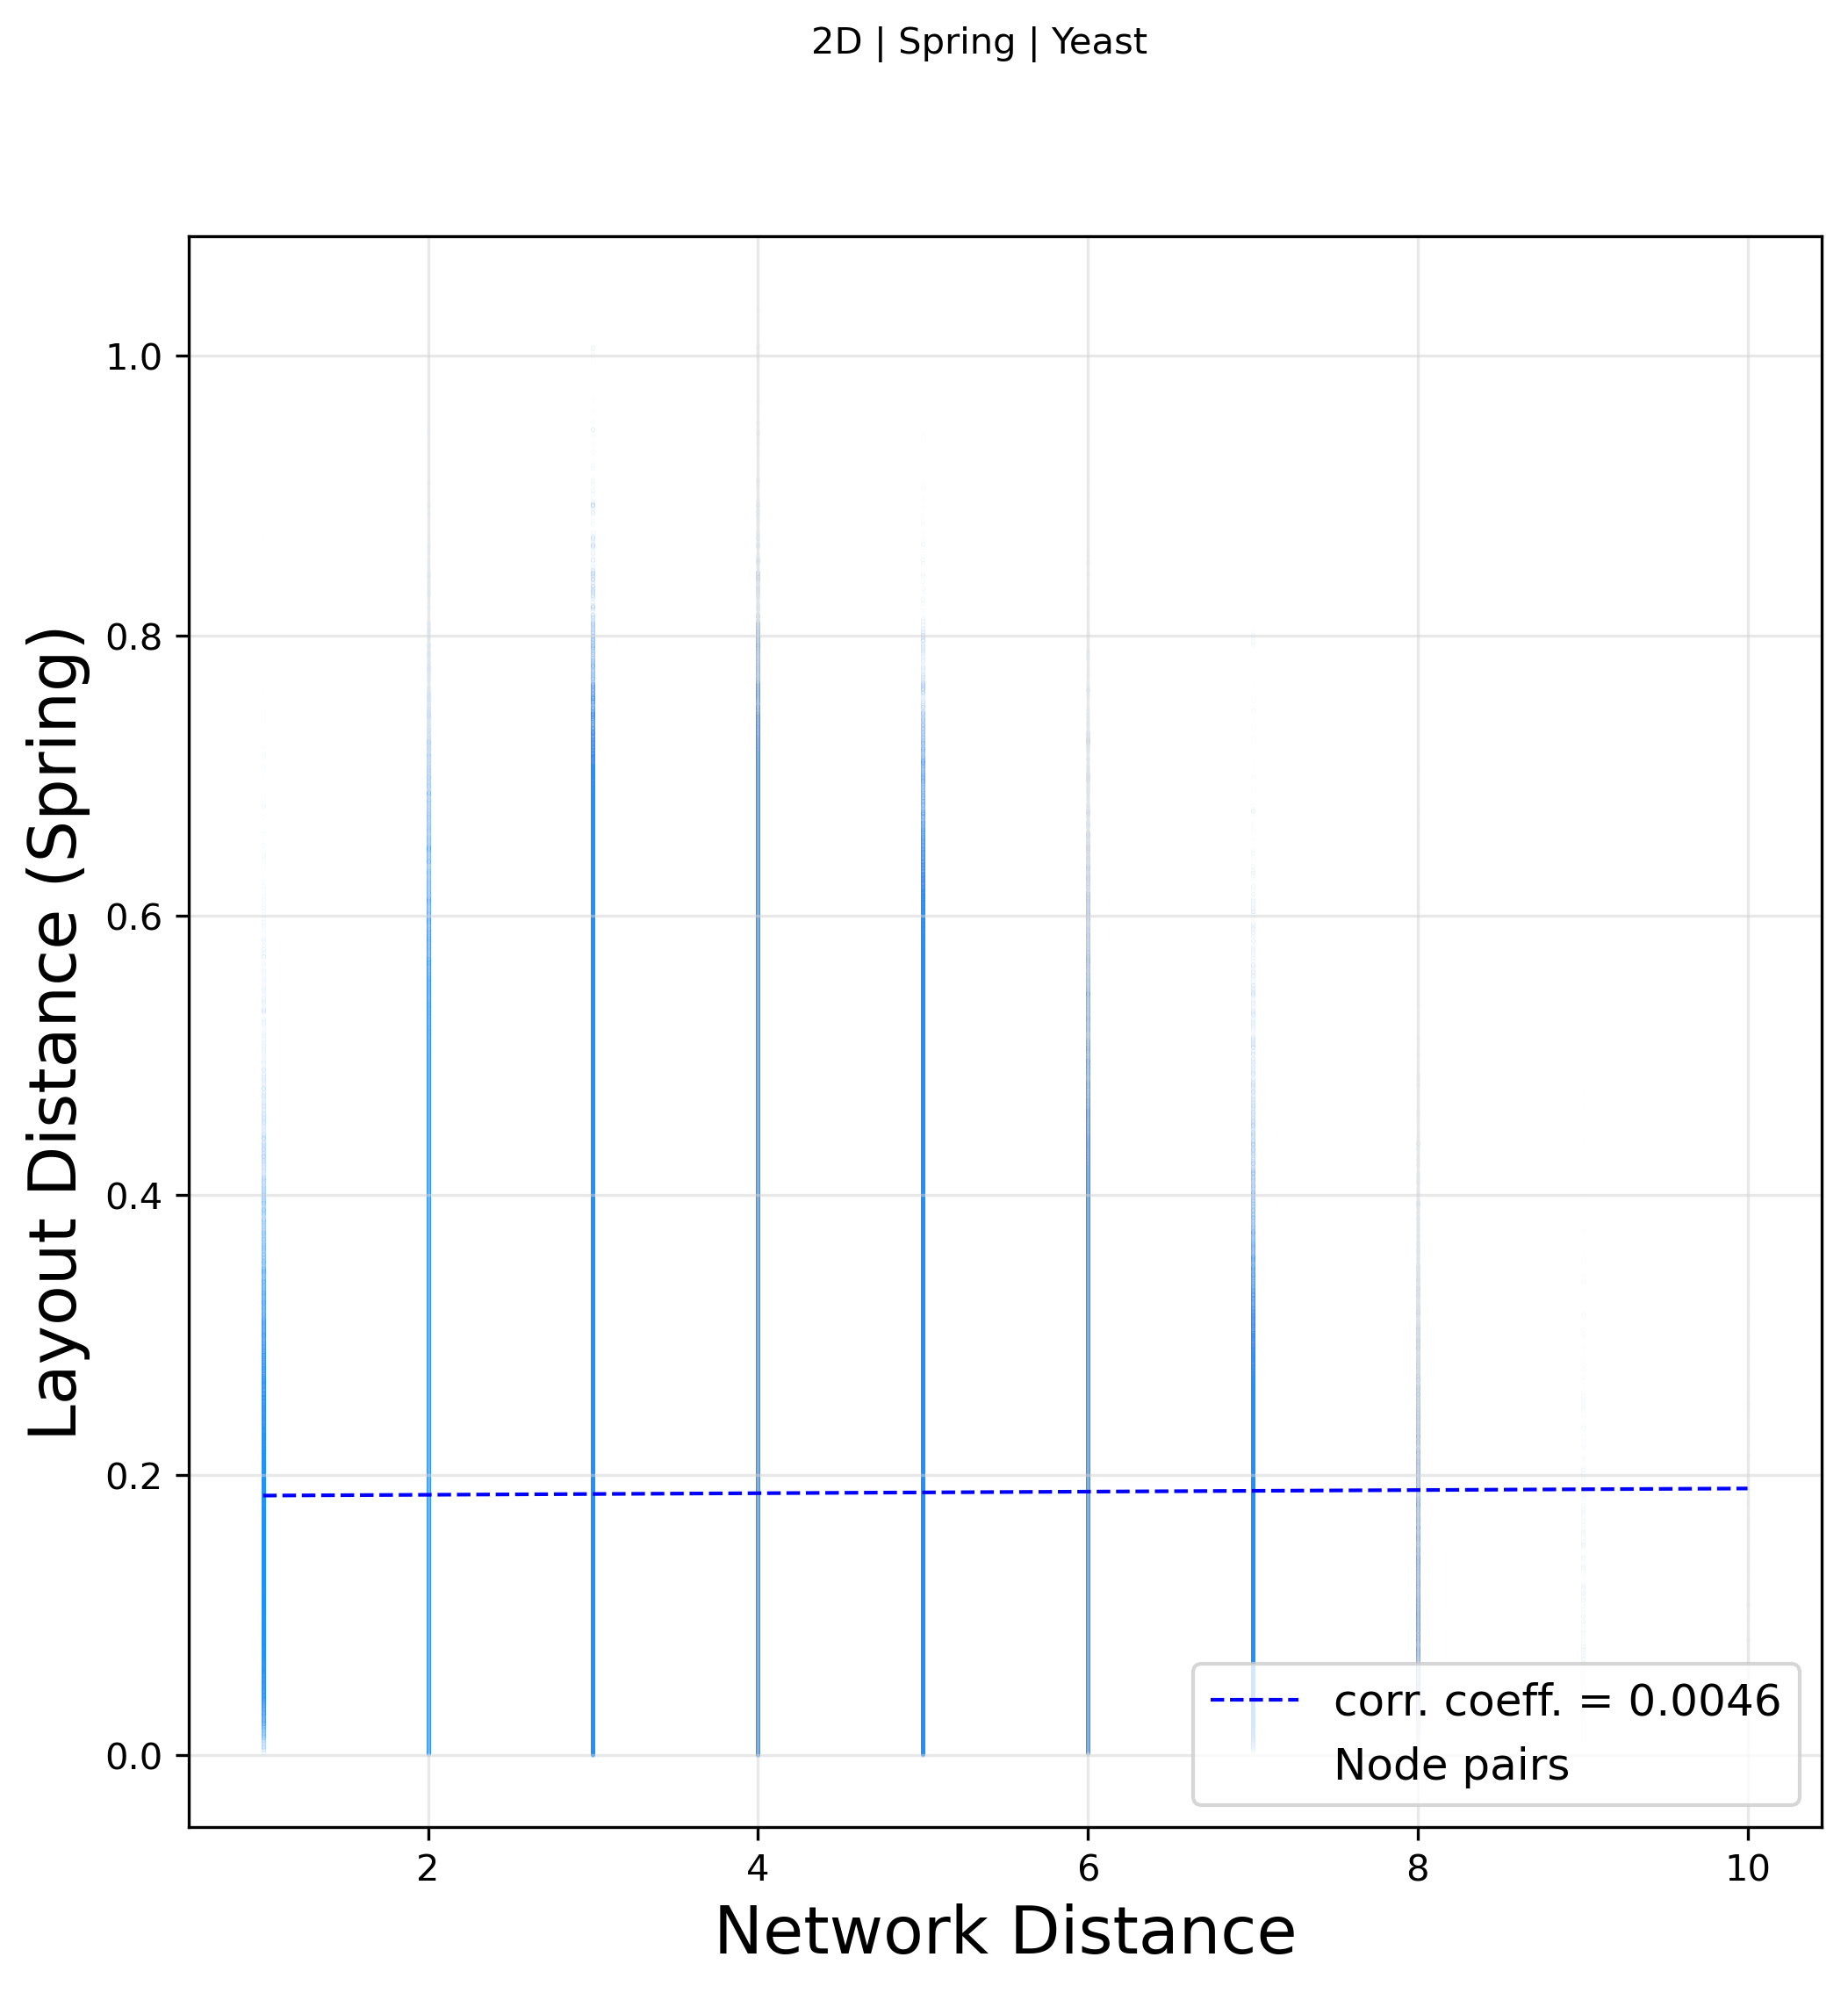

In [108]:
posG_spring2D = posG_spring2D_norm

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

# SPRING
dist_spring2D = {} 
for (id1,p1),(id2,p2) in it.combinations(posG_spring2D.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_spring2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

y_spring = list(dist_spring2D.values())
x_spring = list(dist_network.values())
plt.scatter(x_spring,y_spring, c = 'dodgerblue', s = 0.00005, alpha=0.5)

# REGRESSION LINE 
gradient_spring, intercept_spring, r_value_spring, p_value_spring, std_err_spring = stats.linregress(x_regr_spring,y_regr_spring)
mn_spring= min(x_spring)
mx_spring= max(x_spring)
x1_spring=np.linspace(mn_spring,mx_spring,500)
line_spring =gradient_spring*x1_spring+intercept_spring
plt.plot(x1_spring,line_spring,'--b',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)

plt.legend(('corr. coeff. = {}'.format(round(r_value_spring,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | Spring | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring,intercept_spring), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_SPRING_'+niter+'_'+organism+'.png')

+ RANDOM WALK 

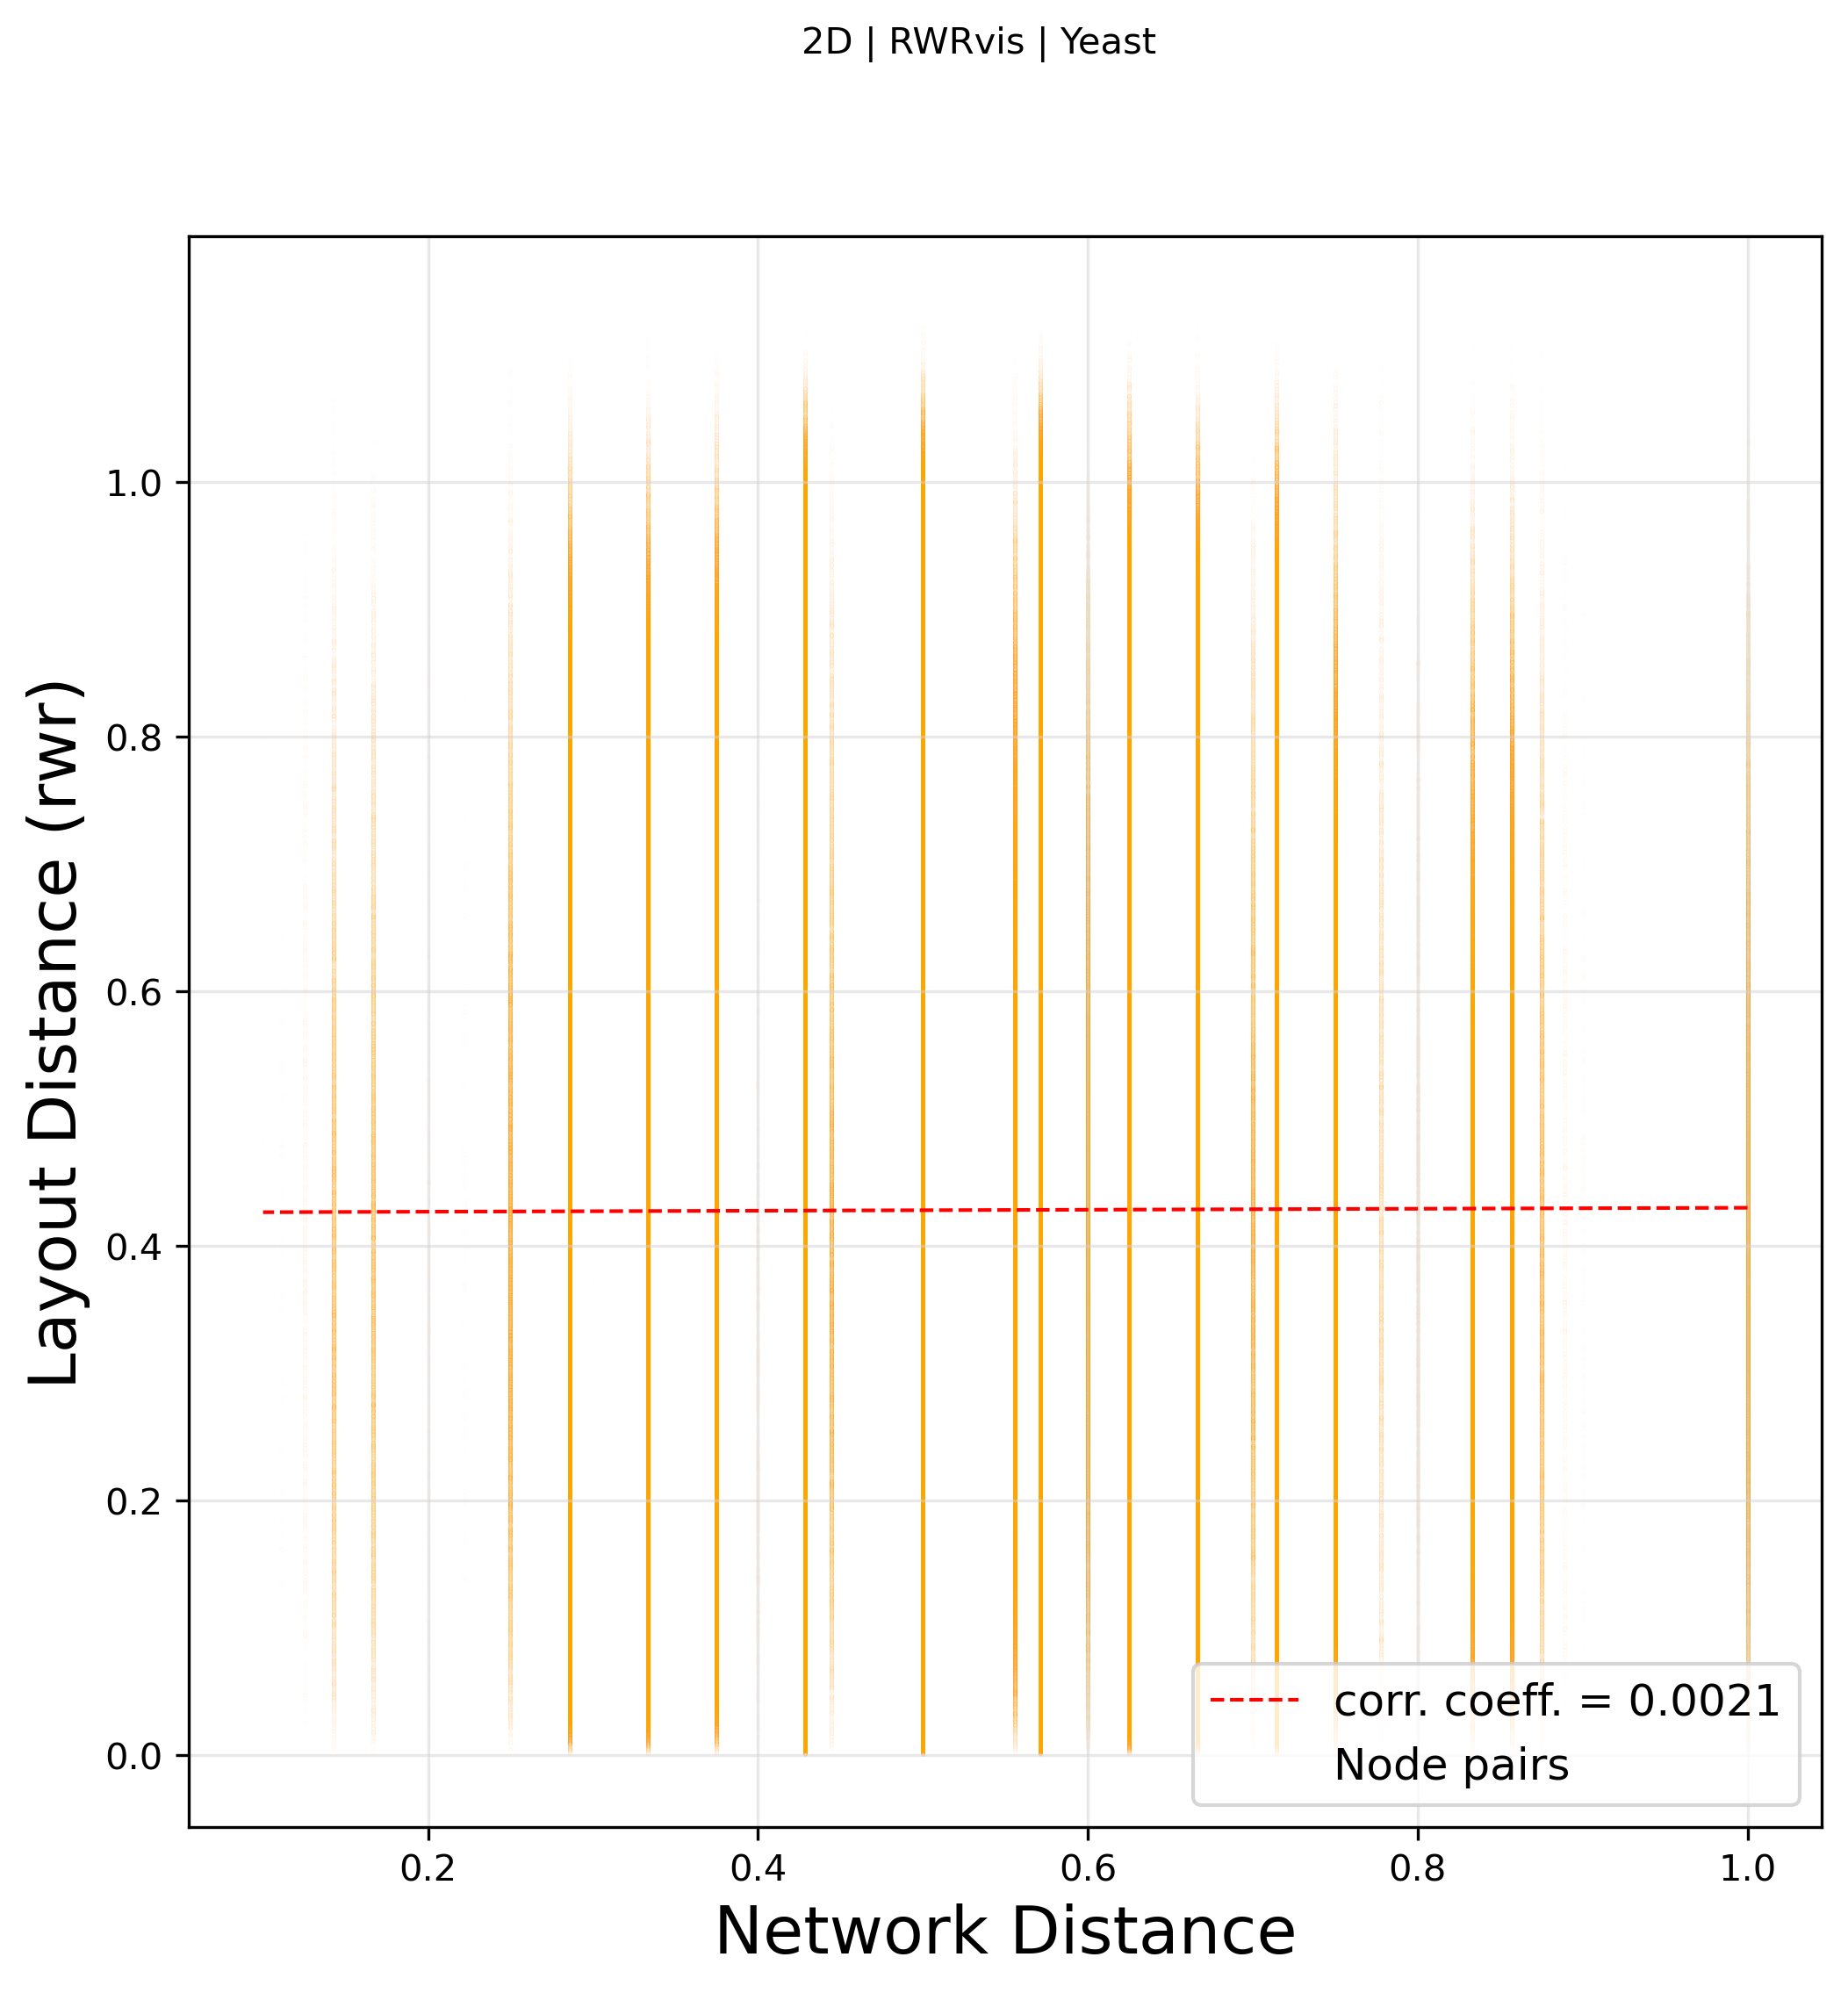

In [115]:
feature = 'RWRvis'
DM = FM_m_transposed
posG_complete_umap = posG_complete_umap_rwr_norm 

DM_spl = df_spl
#DM_spl = DM_spl_norm

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]
    
# LAYOUT 
dist_layout2D = {}
for (id1,p1),(id2,p2) in it.combinations(posG_complete_umap.items(),2):
    dx,dy = p1[0]-p2[0], p1[1]-p2[1]
    dist_layout2D[id1,id2] = np.sqrt(dx*dx+dy*dy)

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout = list(dist_layout2D.values())
x_layout = list(dist_network.values())
plt.scatter(x_layout,y_layout, c = 'orange', s = 0.00005, alpha = 0.5)

# REGRESSION LINE 
gradient_layout, intercept_layout, r_value_layout, p_value_layout, std_err_layout = stats.linregress(x_layout,y_layout)
mn_layout = min(x_layout)
mx_layout = max(x_layout)
x1_layout=np.linspace(mx_layout,mn_layout,500)
line_layout = gradient_layout*x1_layout+intercept_layout
plt.plot(x1_layout,line_layout,'--r',linewidth=1.0)

plt.grid(True, c='lightgrey', alpha=0.5)
plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)
plt.legend(('corr. coeff. = {}'.format(round(r_value_layout,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

plt.suptitle('2D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout,intercept_layout), fontsize=legendfontsize)

fig.savefig('output_plots/2Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+metric+'_'+color_method+'_'+str(n_neighbors)+'_'+str(spread)+'_'+str(min_dist)+'_'+organism+'.png')

______________
# 3D BENCHMARK - visual + statistical 
______________

## SPRING

In [69]:
%%time 

posG_spring3D  = nx.spring_layout(G, iterations = 10, dim = 3)

df_posG = pd.DataFrame(posG_spring3D).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_spring3D_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

spring_nodes = get_trace_nodes_3D(posG_spring3D_norm, None, colours, 4) #size3d)
spring_edges = get_trace_edges_3D(G, posG_spring3D_norm, edge_colordark, opac=1)

spring_data = [spring_nodes, spring_edges]

print('Spring Layout:', organism)

fig = pgo.Figure()
for i in spring_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_'+'spring_'+organism+'.html', auto_open=True)

Spring Layout: Yeast
CPU times: user 20.1 s, sys: 887 ms, total: 21 s
Wall time: 17.7 s


'output_plots/3Dtoynetwork_spring_Yeast.html'

## 3D PORTRAITS

+ ADJACENCIES

In [70]:
%%time 
n_neighbors = 30 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.01 #defines how dense points are stacked together 
metric ='cosine'

feature = 'ADJ'

A = nx.adjacency_matrix(G)
adj = A.toarray()
df_adj = pd.DataFrame(adj, columns = list(G.nodes()), index=list(G.nodes()))
DM = df_adj

umap_3D_adj = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_adj = get_posG_3D(list(G.nodes()), umap_3D_adj)
posG_3D_complete_umap_adj = {key:posG_3Dumap_adj[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_adj).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_adj_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_adj_nodes = get_trace_nodes_3D(posG_3D_complete_umap_adj_norm, None, colours, 4, opac = 0.8) # size3d)
umap_adj_edges = get_trace_edges_3D(G, posG_3D_complete_umap_adj_norm, edge_colordark, 1.0) 

umap_adj_data = [umap_adj_edges, umap_adj_nodes]

fig = pgo.Figure()
for i in umap_adj_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:125: UserWarning:

A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 14345 edges.
It has only fully disconnected 60 vertices.
Use umap.utils.disconnected_vertices() to identify them.



CPU times: user 1min 34s, sys: 1min 16s, total: 2min 51s
Wall time: 2min 54s


'output_plots/3Dtoynetwork_umap_ADJ_Yeast.html'

+ RANDOM WALK - visiting probability

In [75]:
%%time 
n_neighbors = 20 # balance between local and global structure in the data
spread = 10.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

feature = 'RWRvis'

r = .9 # restart probability; originally 0.8
alpha = 1.0
# alpha = 0.5 # --> better results for torus 

FM_m_array = rnd_walk_matrix2(A, r, alpha, len(G.nodes()))
FM_m = pd.DataFrame(FM_m_array)
FM_m_transposed = FM_m.T

DM=FM_m_transposed

umap_rwr_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_rwr = get_posG_3D(list(G.nodes()), umap_rwr_3D)
posG_3D_complete_umap_rwr = {key:posG_3Dumap_rwr[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_rwr).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_rwr_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_rwr_nodes = get_trace_nodes_3D(posG_3D_complete_umap_rwr_norm, None, colours, 4, opac = 0.8) # size3d)
umap_rwr_edges = get_trace_edges_3D(G, posG_3D_complete_umap_rwr_norm, edge_colordark, 1.0) 

umap_rwr_data = [umap_rwr_edges, umap_rwr_nodes]

fig = pgo.Figure()
for i in umap_rwr_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

/Users/chris/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1330: RuntimeWarning:

divide by zero encountered in power



CPU times: user 58.2 s, sys: 2.45 s, total: 1min
Wall time: 20.3 s


'output_plots/3Dtoynetwork_umap_RWRvis_Yeast.html'

+ CENTRALITIES

In [72]:
%%time 

n_neighbors = 20 # balance between local and global structure in the data
spread = 1.0
min_dist = 0.1 #defines how dense points are stacked together 
metric ='cosine'

feature = 'CENT'

DM = DM_cent
umap_cent_3D = embed_umap_3D(DM, n_neighbors, spread, min_dist, metric)

posG_3Dumap_cent = get_posG_3D(list(G.nodes()), umap_cent_3D)
posG_3D_complete_umap_cent = {key:posG_3Dumap_cent[key] for key in G.nodes()}

df_posG = pd.DataFrame(posG_3D_complete_umap_cent).T

x = df_posG.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_posG_norm = pd.DataFrame(x_scaled)

posG_3D_complete_umap_cent_norm = dict(zip(list(G.nodes()),zip(df_posG_norm[0].values,df_posG_norm[1].values,df_posG_norm[2].values)))

umap_cent_nodes = get_trace_nodes_3D(posG_3D_complete_umap_cent_norm, None, colours, 4, opac = 0.8) # size3d)
umap_cent_edges = get_trace_edges_3D(G, posG_3D_complete_umap_cent_norm, edge_colordark, 1.0) 

umap_cent_data = [umap_cent_edges, umap_cent_nodes]

fig = pgo.Figure()
for i in umap_cent_data:
    fig.add_trace(i)

fig.update_layout(template='plotly_white', showlegend=False, width=1200, height=1200,
                  scene=dict(
                      xaxis_title='',
                      yaxis_title='',
                      zaxis_title='',
                      xaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      yaxis=dict(nticks=0,tickfont=dict(
                            color='white')),
                      zaxis=dict(nticks=0,tickfont=dict(
                            color='white')),    
                    dragmode="turntable",
                    #annotations=annotations,
                ))    
#py.iplot(fig)

plotly.offline.plot(fig, filename = 'output_plots/3Dtoynetwork_umap_'+feature+'_'+organism+'.html', auto_open=True)

CPU times: user 1min 8s, sys: 46.1 s, total: 1min 54s
Wall time: 1min 51s


'output_plots/3Dtoynetwork_umap_CENT_Yeast.html'

_________

# EVALUATION - 3D
### Network Distance vs. Layout Distance 
+ Plots to compare Network Distances (i.e. SPL) with embedded Layout Distances 
+ X-axis = Reference axis i.e. Network Distance 
+ Y-axis = Layout Distance 

## 3D layouts Correlation diagrams (NETWORK DISTANCE vs. LAYOUT DISTANCE)

+ SPRING

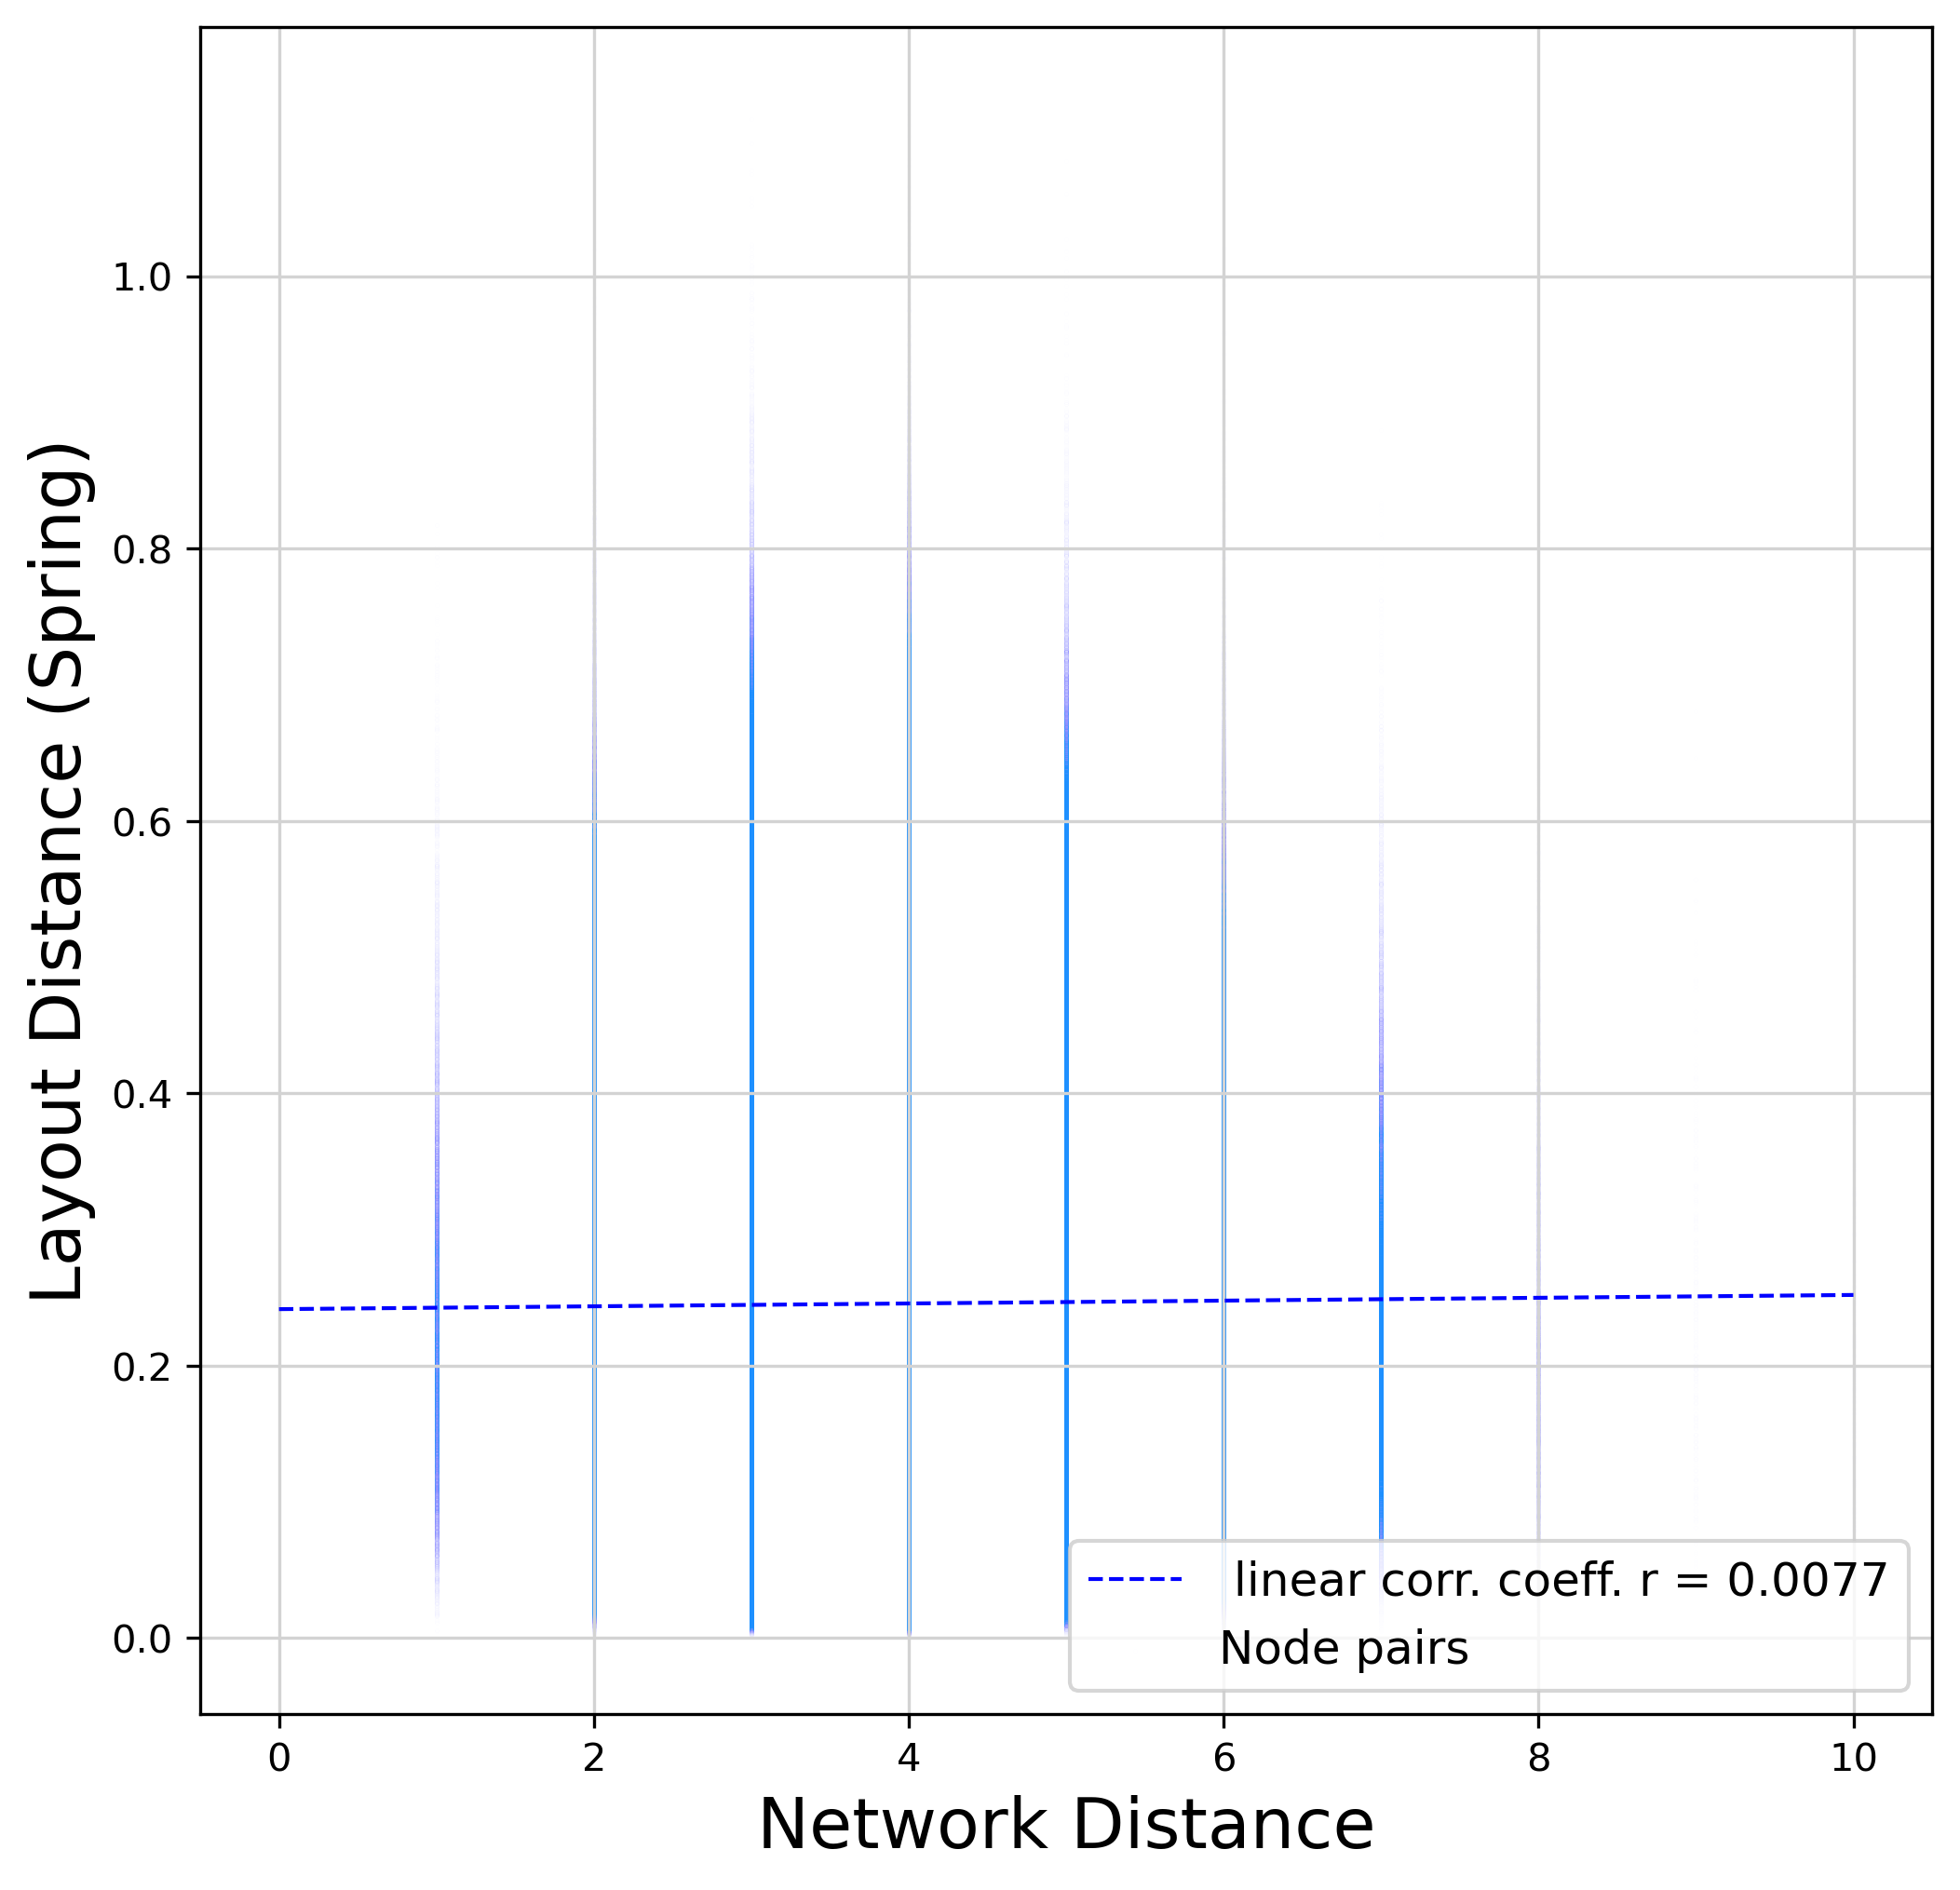

In [73]:
posG_spring3D = posG_spring3D_norm

DM_spl = df
#DM_spl = DM_spl_norm

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

dist_spring3D = dict()
for (id1,p1),(id2,p2) in it.combinations(posG_spring3D.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_spring3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

# ------------------------------------------------------------
# get squareform dataframes from distances

dist_spring_list = [dist[1] for dist in sorted(dist_spring3D.items())]
df_spring3D = pd.DataFrame(dist.squareform(dist_spring_list), index=DM.index, columns=DM.columns)

# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM to compare layouts with
m,n = DM_spl.shape
DM_spl_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM_spl))

m,n = df_spring3D.shape
df_spring3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_spring3D))

# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line


# Network DM to compare layouts with 
l_DM_spl = []
for i in range(len(DM_spl_mod)):
    l_DM_spl.append(DM_spl.iloc[i:i+1].values)

l_DM_spl_un = list(it.chain(*l_DM_spl))
l_DM_spl_flattened = list(it.chain(*l_DM_spl_un))


# SPRING 
l_spring3D = []
for i in range(len(df_spring3D_mod)):
    l_spring3D.append(df_spring3D.iloc[i:i+1].values)

l_spring3D_un = list(it.chain(*l_spring3D))
l_spring3D_flattened = list(it.chain(*l_spring3D_un))


# ------------------------------------------------------------
# PLOT SPRING
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)

y_spring3D = df_spring3D_mod
x_spring3D = DM_spl_mod
plt.scatter(x_spring3D,y_spring3D, c = 'dodgerblue', s = 0.000005, alpha = 0.5)

# REGRESSION LINE 
y_regr_spring3D = l_spring3D_flattened
x_regr_spring3D = l_DM_spl_flattened
gradient_spring3D, intercept_spring3D, r_value_spring3D, p_value_spring3D, std_err_spring3D = stats.linregress(x_regr_spring3D,y_regr_spring3D)
mn_spring3D=np.min(x_regr_spring3D)
mx_spring3D=np.max(x_regr_spring3D)
x1_spring3D=np.linspace(mn_spring3D,mx_spring3D,500)
line_spring3D =gradient_spring3D*x1_spring3D+intercept_spring3D
plt.plot(x1_spring3D,line_spring3D,'--b',linewidth=1.0)

plt.ylabel("Layout Distance (Spring)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.grid(True, c='lightgrey')

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_spring3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

#plt.suptitle('3D | Spring | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_spring3D,intercept_spring3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_SPRING_'+organism+'.png')

+ RANDOM WALK

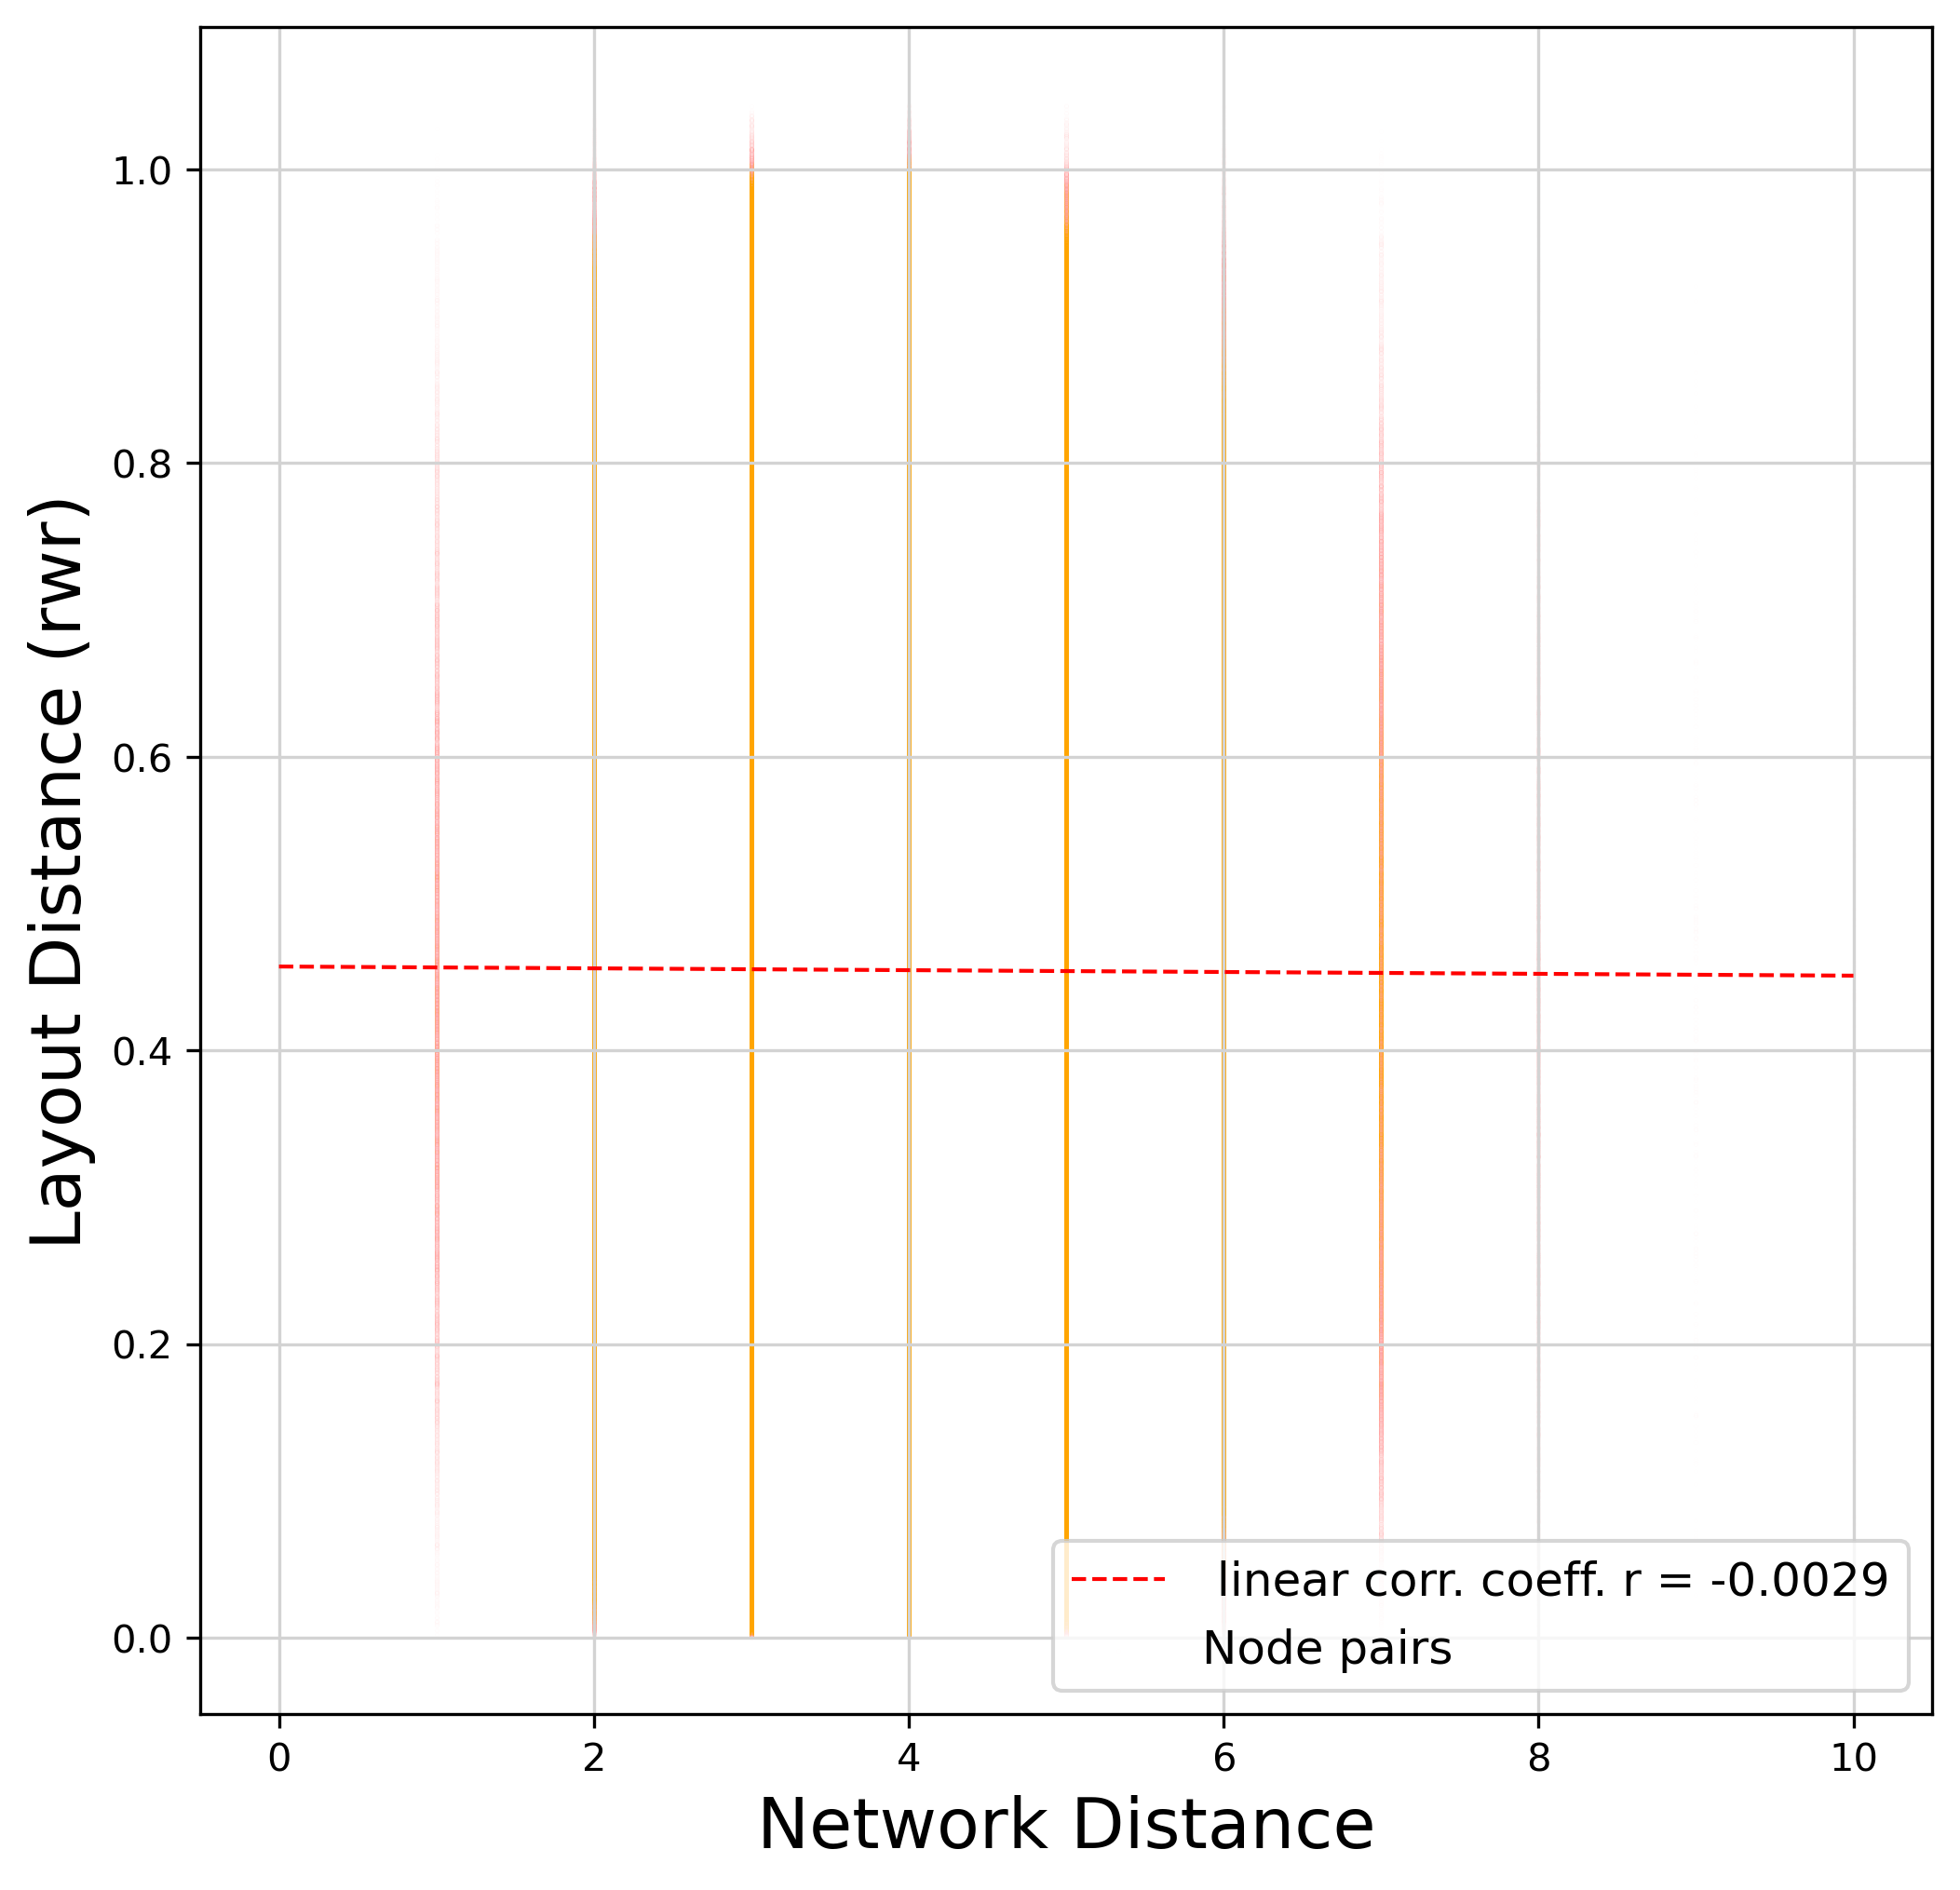

In [76]:
feature = 'RWRvis'
posG_3D_complete_umap = posG_3D_complete_umap_rwr_norm 

DM_spl = df 

# NETWORK DISTANCE
dist_network = {}
for p1, p2 in it.combinations(DM_spl.index,2):
    dist_network[p1,p2] = DM_spl[p1][p2]

dist_layout3D = {}
for (id1,p1),(id2,p2) in it.combinations(posG_3D_complete_umap.items(),2):
    dx,dy,dz = p1[0]-p2[0], p1[1]-p2[1], p1[2]-p2[2]
    dist_layout3D[id1,id2] = math.sqrt(dx*dx+dy*dy+dz*dz)

# ------------------------------------------------------------
# get squareform dataframes from distances

# NETWORK DM to compare layouts with
m,n = DM_spl.shape
DM_spl_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,DM_spl))

dist_layout_list = [dist[1] for dist in sorted(dist_layout3D.items())]
df_layout3D = pd.DataFrame(dist.squareform(dist_layout_list), index=DM.index, columns=DM.columns)

# ------------------------------------------------------------
# remove all diagonal 0 values and values underneath diagonale (i.e. mirrored data)

# NETWORK DM # stays the same as in 2D correlations 
#DM_spl_mod

m,n = df_layout3D.shape
df_layout3D_mod = pd.DataFrame(np.where(np.arange(m)[:,None] >= np.arange(n),np.nan,df_layout3D))

# ------------------------------------------------------------
# values of Dataframe into flattened list for Regression line

# Network DM to compare layouts with 
l_DM_spl = []
for i in range(len(DM_spl_mod)):
    l_DM_spl.append(DM_spl.iloc[i:i+1].values)

l_layout3D = []
for i in range(len(df_layout3D_mod)):
    l_layout3D.append(df_layout3D.iloc[i:i+1].values)

l_layout3D_un = list(it.chain(*l_layout3D))
l_layout3D_flattened = list(it.chain(*l_layout3D_un))


# ------------------------------------------------------------
# PLOT LAYOUT
# ------------------------------------------------------------

fig = plt.figure(figsize=(8,8), dpi=300)

y_layout3D = df_layout3D_mod
x_layout3D = DM_spl_mod
plt.scatter(x_layout3D,y_layout3D, c = 'orange', s = 0.000005, alpha = 0.5)

# REGRESSION LINE 
y_regr_layout3D = l_layout3D_flattened
x_regr_layout3D = l_DM_spl_flattened
gradient_layout3D, intercept_layout3D, r_value_layout3D, p_value_layout3D, std_err_layout3D = stats.linregress(x_regr_layout3D,y_regr_layout3D)
mn_layout3D=np.min(x_regr_layout3D)
mx_layout3D=np.max(x_regr_layout3D)
x1_layout3D=np.linspace(mn_layout3D,mx_layout3D,500)
line_layout3D = gradient_layout3D*x1_layout3D+intercept_layout3D
plt.plot(x1_layout3D,line_layout3D,'--r',linewidth=1.0)

plt.ylabel("Layout Distance "+"(rwr)", fontsize=labelsize)
plt.xlabel("Network Distance", fontsize=labelsize)

plt.grid(True, c='lightgrey')

plt.legend((' linear corr. coeff. r = {}'.format(round(r_value_layout3D,4)),'Node pairs'), loc='lower right', fontsize = legendfontsize)

#plt.suptitle('3D | '+feature+' | '+organism, fontsize=10)
#plt.title('y = {:.2f}x+{:.2f}'.format(gradient_layout3D,intercept_layout3D), fontsize=legendfontsize)

fig.savefig('output_plots/3Dtoynetwork_NetworkDistance_LAYOUT_'+feature+'_'+organism+'.png')